In [1]:
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Customer Churn Prediction

### 1) Data Loading and Inspection

In [2]:
# Load data
df = pd.read_csv("Telco Customer Churn.csv")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# Drop customerID
df = df.drop(columns = ["customerID"])
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# Find unique values in each column
numerical_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in df.columns:
    if col not in numerical_cols:
        print(col, df[col].unique())
        print("-" * 52)

gender ['Female' 'Male']
----------------------------------------------------
SeniorCitizen [0 1]
----------------------------------------------------
Partner ['Yes' 'No']
----------------------------------------------------
Dependents ['No' 'Yes']
----------------------------------------------------
PhoneService ['No' 'Yes']
----------------------------------------------------
MultipleLines ['No phone service' 'No' 'Yes']
----------------------------------------------------
InternetService ['DSL' 'Fiber optic' 'No']
----------------------------------------------------
OnlineSecurity ['No' 'Yes' 'No internet service']
----------------------------------------------------
OnlineBackup ['Yes' 'No' 'No internet service']
----------------------------------------------------
DeviceProtection ['No' 'Yes' 'No internet service']
----------------------------------------------------
TechSupport ['No' 'Yes' 'No internet service']
----------------------------------------------------
StreamingTV ['N

In [7]:
df[df["TotalCharges"]==" "]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [8]:
# Replace null entries in TotalCharges with 0
df["TotalCharges"] = df["TotalCharges"].replace({" ": "0.0"})
df["TotalCharges"] = df["TotalCharges"].astype(float)
df[df["TotalCharges"]== " "]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [9]:
# Check for class imbalance in the target column
print(df["Churn"].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


### 2) Exploratory Data Analysis

We will first analyze and gain a deep understanding of the **quantitative** data.

In [10]:
# Plot the distribution of the quantitative data using a histogram and boxplot
def plot_distribution(df, column_name):
    
    # Plot for each column should be side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  

    # Histogram 
    sns.histplot(df[column_name], kde=True, ax=axes[0])

    # Vertical line for mean and median
    axes[0].axvline(df[column_name].mean(), color="red", linestyle="--", label="Mean")
    axes[0].axvline(df[column_name].median(), color="orange", linestyle="-.", label="Median")

    axes[0].set_title(f"Distribution of {column_name}")
    axes[0].legend()

    # Box plot
    sns.boxplot(y=df[column_name], ax=axes[1])
    axes[1].set_title(f"Box Plot of {column_name}")
    axes[1].set_ylabel(column_name)

    plt.tight_layout()
    plt.show()

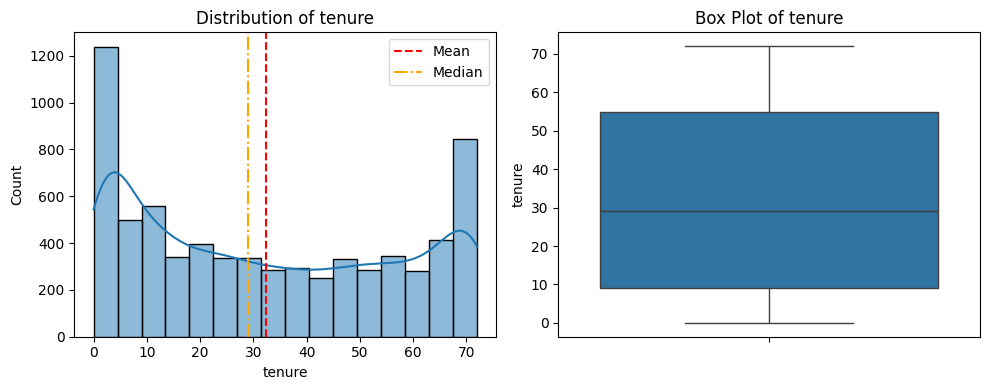

In [11]:
plot_distribution(df, "tenure")

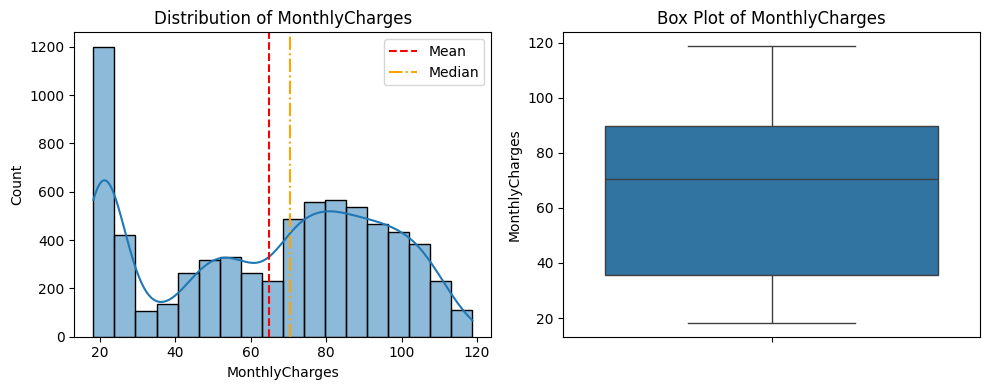

In [12]:
plot_distribution(df, "MonthlyCharges")

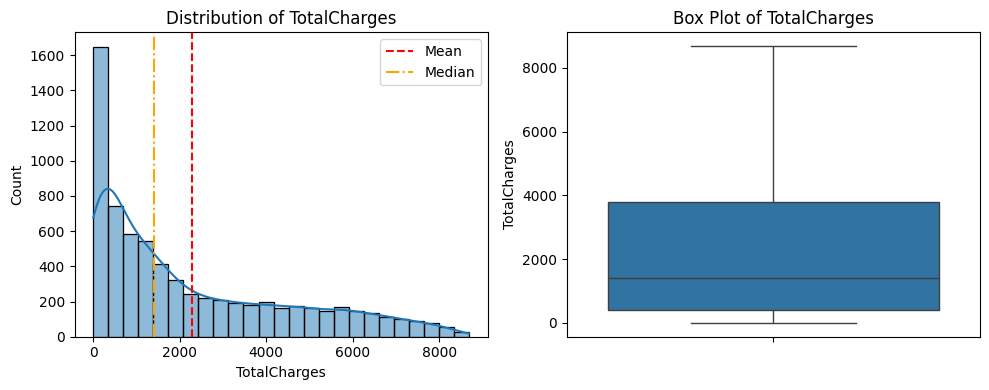

In [13]:
plot_distribution(df, "TotalCharges")

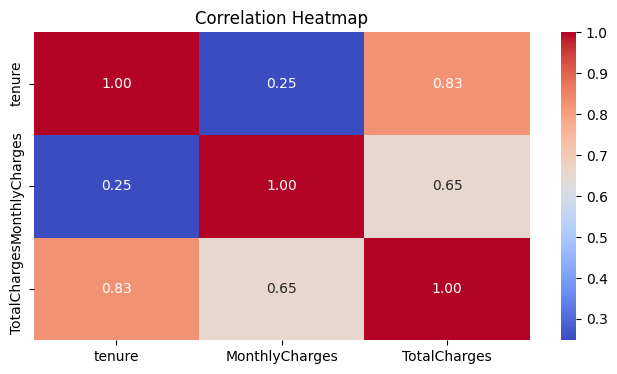

In [14]:
# Correlation Heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df[["tenure", "MonthlyCharges", "TotalCharges"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Now we shift our focus to the **qualitative** data.

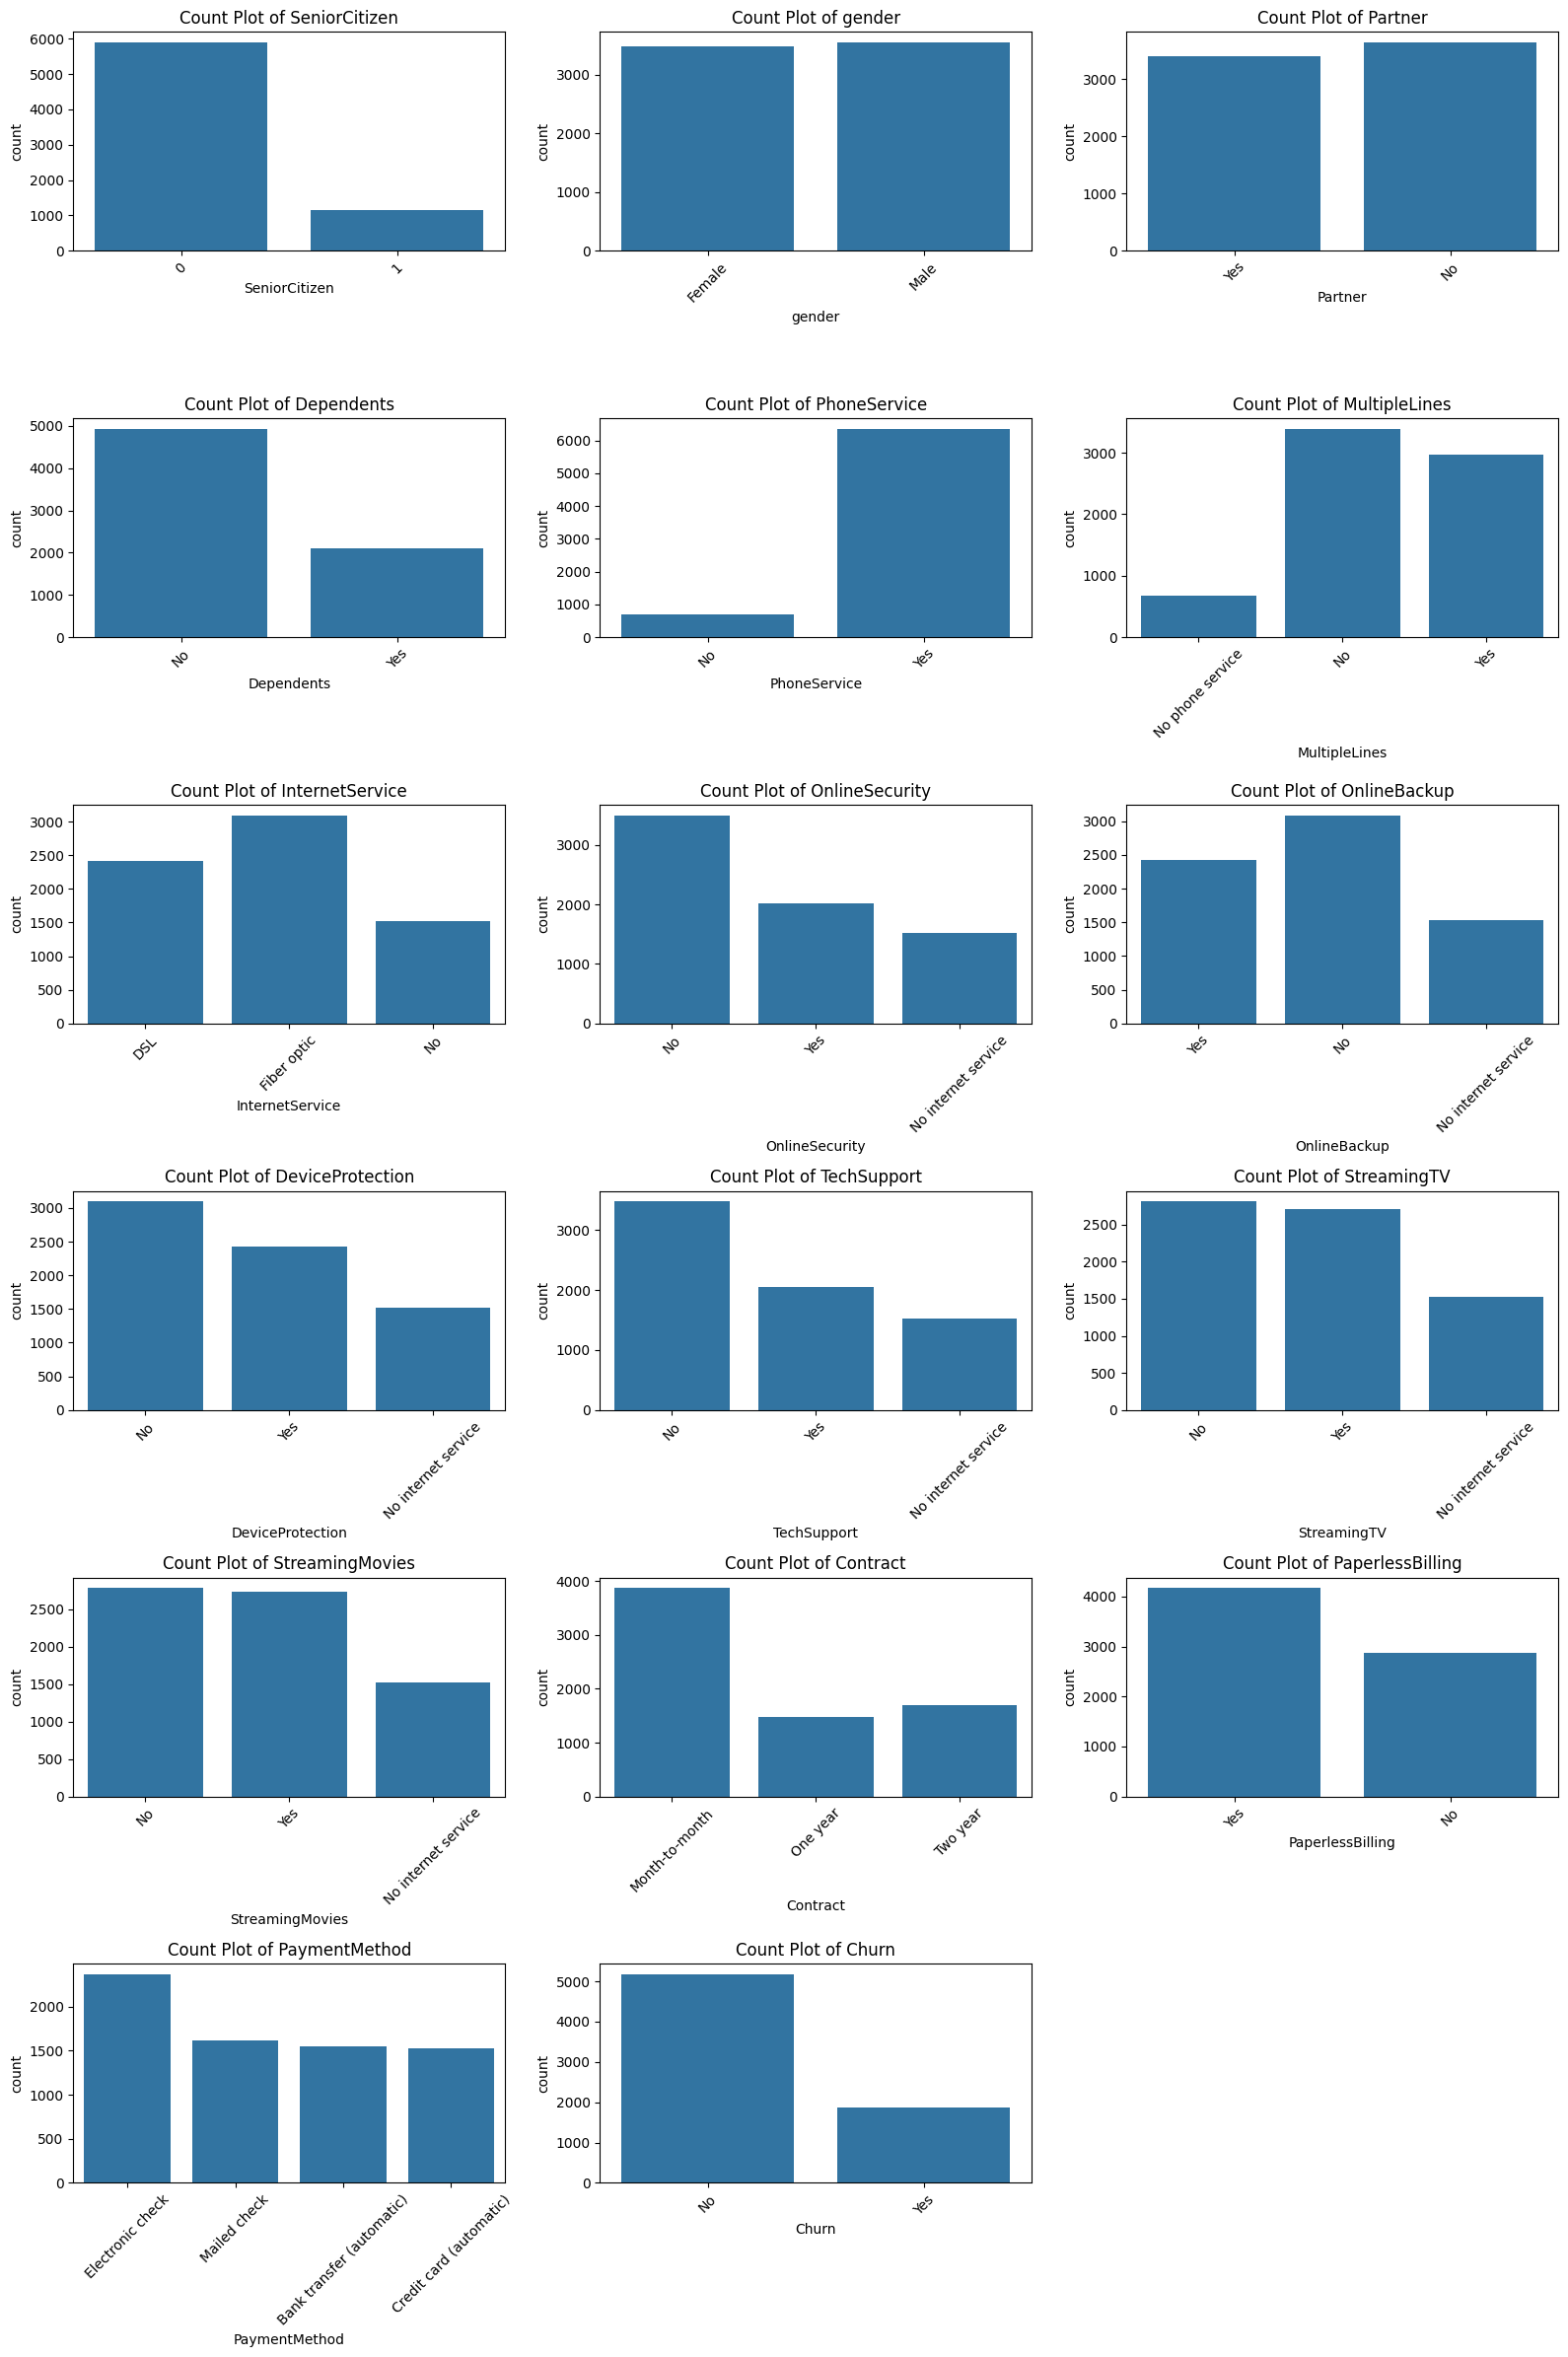

In [15]:
# Count plot for each categorical columns

# Get all categorical columns
cat_vals = df.select_dtypes(include="object").columns.to_list()
cat_vals = ["SeniorCitizen"] + cat_vals

# Create a 5x5 grid to display all the plots
n_rows = math.ceil(len(cat_vals) / 3)
fig, axes = plt.subplots(n_rows, 3, figsize=(16, 4 * n_rows))
axes = axes.flatten() 

# Loop through each column
for i, col in enumerate(cat_vals):
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Count Plot of {col}")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### 3) Data Preprocessing

In [16]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Label encoding of the target column
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [17]:
# Label encoding of the categorical columns

# Finding all object columns
object_cols = df.select_dtypes(include="object").columns

# Dictionary to save encoders
encoders = {}

# Loop through all object columns
for column in object_cols:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])
  encoders[column] = label_encoder

# Save to pickle file
with open("encoders.pkl", "wb") as f:
  pickle.dump(encoders, f)

In [18]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [19]:
# Split into Train/Test Data
X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y_train.value_counts())

Churn
0    4138
1    1496
Name: count, dtype: int64


From the above, we see that there is a class imbalance so we will now apply the Synthetic Minority Oversampling Technique (SMOTE) to address this.

In [20]:
X_train_smote, y_train_smote = SMOTE(random_state=42).fit_resample(X_train, y_train)
print(y_train_smote.shape)
print("-" * 25)
print(y_train_smote.value_counts())

(8276,)
-------------------------
Churn
0    4138
1    4138
Name: count, dtype: int64


### 4) Model Training

In [21]:
# Dictionary of models
models = {"Decision Tree": DecisionTreeClassifier(random_state=42),
          "Random Forest": RandomForestClassifier(random_state=42),
          "XGBoost": XGBClassifier(random_state=42)}

# Dictionary to store the cross validation results
cv_results = {}

# 5-fold cross validation
for name, model in models.items():
  print(f"{name}")
  scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring="accuracy")
  cv_results[name] = scores 
  print(f"Cross-Validation Accuracy: {np.mean(scores):.2f}")
  print("-"*35)

Decision Tree
Cross-Validation Accuracy: 0.78
-----------------------------------
Random Forest
Cross-Validation Accuracy: 0.84
-----------------------------------
XGBoost
Cross-Validation Accuracy: 0.83
-----------------------------------


Random Forest gives the highest accuracy compared to other models when using default parameters.

In [22]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_smote, y_train_smote)
print("-"*35)
print(y_test.value_counts())

-----------------------------------
Churn
0    1036
1     373
Name: count, dtype: int64


### 5) Model Evaluation

In [23]:
# Evaluate
y_test_pred = rfc.predict(X_test)
print("Accuracy Score:\n", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

Accuracy Score:
 0.7785663591199432

Confusion Matrix:
 [[878 158]
 [154 219]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1036
           1       0.58      0.59      0.58       373

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



In [24]:
# Save trained model
model_data = {"model": rfc, "columns": X.columns.tolist()}
with open("customer_churn_model.pkl", "wb") as f:
  pickle.dump(model_data, f)

### 6) Build Predictive System

In [25]:
# Load the saved model
with open("customer_churn_model.pkl", "rb") as f:
  model_data = pickle.load(f)

loaded_model = model_data["model"]

# Build Predictive System
pred_data = {'gender': 'Male',
              'SeniorCitizen': 0,
              'Partner': 'No',
              'Dependents': 'No',
              'tenure': 34,
              'PhoneService': 'Yes',
              'MultipleLines': 'No',
              'InternetService': 'DSL',
              'OnlineSecurity': 'Yes',
              'OnlineBackup': 'No',
              'DeviceProtection': 'Yes',
              'TechSupport': 'No',
              'StreamingTV': 'No',
              'StreamingMovies': 'Yes',
              'Contract': 'One year',
              'PaperlessBilling': 'No',
              'PaymentMethod': 'Mailed check',
              'MonthlyCharges': 56.95,
              'TotalCharges': 1889.5}

pred_data_df = pd.DataFrame([pred_data])

with open("encoders.pkl", "rb") as f:
  encoders = pickle.load(f)

# Apply previously saved label encoders
for column, encoder in encoders.items():
  pred_data_df[column] = encoder.transform(pred_data_df[column])

# Prediction
prediction = loaded_model.predict(pred_data_df)
probability = loaded_model.predict_proba(pred_data_df)

# Results
print(f"Prediction: {'Churn' if prediction[0] == 1 else 'No Churn'}")
print(f"Probability: {probability}")

Prediction: No Churn
Probability: [[0.94 0.06]]
